In [1]:
import pandas as pd 
    
train = pd.read_csv('../data/kaggle_bias/train.csv')

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
!pip install datasets transformers huggingface_hub


In [2]:
# adds binary column and gets rid of the null values in the data

train = train.dropna(subset=['comment_text'])
train.reset_index(drop=True, inplace=True)
train['bi_target'] = (train['target'] >= 0.5).astype(int)

In [3]:
#take a sample from the train data set, take stratified sample to maintain distribution. 
# train_sample = train.groupby('bi_target', group_keys=False).apply(lambda x: x.sample(frac=0.025, random_state=42))

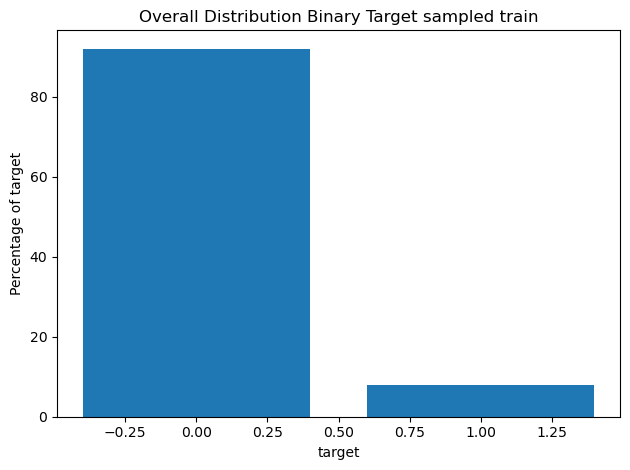

The absolute class distribution is: {0: 41513, 1: 3608}
Count for score 1: 3608
Count for score 0: 41513

The relative (%) class distribution is: 
bi_target
0    92.003723
1     7.996277
Name: proportion, dtype: float64


In [4]:
# import matplotlib.pyplot as plt

# class_distribution = train_sample['bi_target'].value_counts().to_dict()
# overall_count = train_sample['bi_target'].value_counts(normalize=True)*100

# plt.bar(overall_count.index, overall_count.values)
# plt.title('Overall Distribution Binary Target sampled train')
# plt.xlabel('target')
# plt.ylabel('Percentage of target') 

# plt.tight_layout()
# plt.show()
# print(f'The absolute class distribution is:', class_distribution)
# print(f'Count for score 1:', class_distribution[1])
# print(f'Count for score 0:', class_distribution[0])
# print('\nThe relative (%) class distribution is:', f'\n{overall_count}')

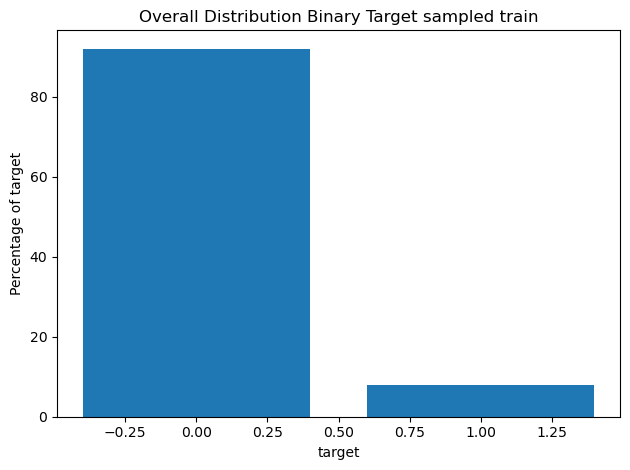

The absolute class distribution is: {0: 1660537, 1: 144334}
Count for score 1: 144334
Count for score 0: 1660537

The relative (%) class distribution is: 
bi_target
0    92.003085
1     7.996915
Name: proportion, dtype: float64


In [7]:
# import matplotlib.pyplot as plt

# class_distribution = train['bi_target'].value_counts().to_dict()
# overall_count = train['bi_target'].value_counts(normalize=True)*100

# plt.bar(overall_count.index, overall_count.values)
# plt.title('Overall Distribution Binary Target sampled train')
# plt.xlabel('target')
# plt.ylabel('Percentage of target') 

# plt.tight_layout()
# plt.show()
# print(f'The absolute class distribution is:', class_distribution)
# print(f'Count for score 1:', class_distribution[1])
# print(f'Count for score 0:', class_distribution[0])
# print('\nThe relative (%) class distribution is:', f'\n{overall_count}')

In [3]:
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import numpy as np

class MyDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['comment_text']
        label = self.dataframe.iloc[idx]['bi_target']
        return text, label





# Collator did speed up the batch size issues, I kept finding articles for collate_fn though.  Not sure what the difference is between this and 
# hugging faces is one but they appear to do the same thing.
def collate_fn(batch):
    texts, labels = zip(*batch)
    encodings = tokenizer(list(texts), padding=True, truncation=True, max_length=215, return_tensors="pt")
    labels = torch.tensor(labels, dtype=torch.long)
    return encodings['input_ids'], encodings['attention_mask'], labels

In [4]:
# almost identical to before except for the loaders 

# tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Split the dataset
train_df, val_df = train_test_split(train, test_size=0.1)

# Dataset
train_dataset = MyDataset(train_df, tokenizer)
val_dataset = MyDataset(val_df, tokenizer)

# num of workers is supposed to speed up the bottleneck between CPU and GPU but I could not get it to run whatsoever.  Setting it to 0 worked fine though
# only difference here is the addition of the collator and changing of the batch size
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=0, collate_fn=collate_fn)

In [5]:
from transformers import DistilBertForSequenceClassification, DistilBertConfig

config = DistilBertConfig(
    n_layers=6,  # Number of hidden layers
    dim=768,  # Dimensionality of the encoder layers and the pooler layer
    hidden_dim=3072,  # Dimensionality of the "intermediate" (i.e., feed-forward) layer in the Transformer encoder
    n_heads=12,  # Number of attention heads for each attention layer in the Transformer encoder
    dropout=0.2,  # Dropout probability for the dropout layers
    attention_dropout=0.2,  # Dropout probability for the attention layers
    num_labels=2
)

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

# makes the model run on the GPU instead of CPU
model.cuda()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.2, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.2, inplace=False)
 

In [13]:
# alternative weighted trainer








# from transformers import AdamW
# from tqdm.auto import tqdm
# from torch.optim.lr_scheduler import StepLR

# # class weight for 5% target class
# class_weights = [1, 1.01]

# # convert class weight to tensor
# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).cuda()


# # AdamW optimizer is apparently really good for DistilBERT?  Will write more in docs
# optimizer = AdamW(model.parameters(), lr=5e-5)

# # Define the scheduler
# scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

# # Training loop
# model.train()
# for epoch in range(3):  
#     scheduler.step()
#     progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
#     for input_ids, attention_mask, labels in progress_bar:
#         # Move the training to the GPU
#         input_ids = input_ids.cuda()
#         attention_mask = attention_mask.cuda()
#         labels = labels.cuda()

#         # Set gradients to zero for training
#         model.zero_grad()
        
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        
#         loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
#         loss = loss_fct(outputs.logits, labels)

#         # loss = outputs.loss
        
#         loss.backward()
#         optimizer.step()
        
#         progress_bar.set_postfix({'loss': loss.item()})

C:\Users\matth\anaconda3\envs\torchpower\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/127 [00:00<?, ?it/s]

In [7]:
# my final trainer




# Optimizer
optimizer = AdamW(model.parameters(), lr=7.5e-5)

# GradScaler for mixed precision training
scaler = GradScaler()

# Scheduler
epochs = 3
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

#scheduler = StepLR(optimizer, step_size=1, gamma=0.1)


# Training loop
model.train()
for epoch in range(epochs):  
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in progress_bar:
        input_ids, attention_mask, labels = [b.cuda() for b in batch]

        # Set gradients to zero for training
        model.zero_grad()
        
        # Mixed precision
        with autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        # Backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        model.zero_grad()

        progress_bar.set_postfix({'loss': loss.item()})

        # Clear some memory
        del input_ids
        del attention_mask
        del labels
        torch.cuda.empty_cache()

C:\Users\matth\anaconda3\envs\torchpower\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1:   0%|          | 0/12691 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/12691 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/12691 [00:00<?, ?it/s]

In [8]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


model.eval()  # Transformers built in model evaluation kit 
true_labels = []
pred_labels = []

with torch.no_grad():  # Disable gradient calculation
    for input_ids, attention_mask, labels in val_loader:
        # Move tensors to the GPU
        input_ids = input_ids.cuda()
        attention_mask = attention_mask.cuda()
        labels = labels.cuda()
        
        # Forward pass, get logit predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Move logits and labels to CPU
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        
        # Store predictions and true labels
        true_labels.append(label_ids)
        pred_labels.append(logits.argmax(axis=1))

# Calculate our accuracy metrics
true_labels = np.concatenate(true_labels)
pred_labels = np.concatenate(pred_labels)


accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='binary')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9538639687957094
Precision: 0.7169382063701747
Recall: 0.6860734602149028
F1 Score: 0.7011663376996232


2.5% of data, batch size 64, no optimization

- Accuracy: 0.9399512519388433
- 
Precision: 0.6460176991150443
- 
Recall: 0.591891891891891
- 8
F1 Score: 0.6177715091678421

2.5% of data, batch size 64, potential optimization?  I'm not sure if it worked

- Accuracy: 0.9412807445158431,- 
Precision: 0.635258358662613,9
- 
Recall: 0.59039548022598,8
- 8
F1 Score: 0.6120058565153,733

2.5% of data, batch size 215, no optimization, Arman's learning rate 

- Accuracy: 0.946155550631509- 
Precision: 0.6735905044510386
- 
Recall: 0.630555555555555
- 5
F1 Score: 0.6513629842180775

2.5%, 128 batch size, undersampling with arman's learning rate 

- Accuracy: 0.9268698060941828- 
Precision: 0.5317622950819673
- 
Recall: 0.718836565096952
- 9
F1 Score: 0.6113074204946997

2.5% 128 batch, arman code 

- Accuracy: 0.9172299168975069- 
Precision: 0.48854262144821264
- 
Recall: 0.738227146814404
- 4
F1 Score: 0.5879757308328736

In [9]:
# from transformers import DistilBertModel


# # Save the model
# model.save_pretrained('../data/models/toxicibert_final')

# # Save the tokenizer
# tokenizer.save_pretrained('../data/models/toxicibert_tokenizer_final')


('../data/toxicibert_tokenizer_final\\tokenizer_config.json',
 '../data/toxicibert_tokenizer_final\\special_tokens_map.json',
 '../data/toxicibert_tokenizer_final\\vocab.txt',
 '../data/toxicibert_tokenizer_final\\added_tokens.json')

100% of data, undersampled.  128 batch size 

- Accuracy: 0.8921147112273392- 
Precision: 0.42045275155495215
- 
Recall: 0.922677198087715
- 6
F1 Score: 0.5776688500412094

In [13]:
# alternative evaluation with different threshhold options

import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model.eval()  # Transformers built-in model evaluation kit 
true_labels = np.array([])
all_pred_labels = []  # Store predictions for each threshold

# Define a list of threshold values to iterate over
thresholds = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for threshold in thresholds:
    true_labels = np.array([])
    pred_labels = np.array([])

    with torch.no_grad():  # Disable gradient calculation
        for input_ids, attention_mask, labels in val_loader:
            # Move tensors to the GPU
            input_ids = input_ids.cuda()
            attention_mask = attention_mask.cuda()
            labels = labels.cuda()

            # Forward pass, get logit predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Apply threshold to logits
            logits = outputs.logits.detach().cpu().numpy()
            pred_probs = torch.softmax(torch.tensor(logits), dim=1)
            pred_labels_thresholded = (pred_probs[:, 1] > threshold).numpy()  # Assuming binary classification

            # Move labels to CPU
            label_ids = labels.to('cpu').numpy()

            # Store predictions and true labels
            true_labels = np.concatenate((true_labels, label_ids))
            pred_labels = np.concatenate((pred_labels, pred_labels_thresholded))

    all_pred_labels.append(pred_labels)

# Convert list of prediction arrays to numpy array
allpred_labels = np.array(all_pred_labels)

# Calculate metrics for each threshold
for i, threshold in enumerate(thresholds):
    pred_labels = all_pred_labels[i]
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _  = precision_recall_fscore_support(true_labels, pred_labels, average='binary')

    print(f'Threshold: {threshold}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print('///////////////////////')

Threshold: 0.4
Accuracy: 0.9502515402686051
Precision: 0.6681800741782836
Recall: 0.7338296228667743
F1 Score: 0.6994678180540215
///////////////////////
Threshold: 0.5
Accuracy: 0.9538639687957094
Precision: 0.7169382063701747
Recall: 0.6860734602149028
F1 Score: 0.7011663376996232
///////////////////////
Threshold: 0.6
Accuracy: 0.9558086964230309
Precision: 0.7721386981837143
Recall: 0.6239904487674697
F1 Score: 0.6902043035811389
///////////////////////
Threshold: 0.7
Accuracy: 0.955293426709809
Precision: 0.8115532215713998
Recall: 0.5643654751035887
F1 Score: 0.6657553539621391
///////////////////////
Threshold: 0.8
Accuracy: 0.9543016710252206
Precision: 0.859215733301355
Recall: 0.5031954491186179
F1 Score: 0.6346886349543803
///////////////////////
Threshold: 0.9
Accuracy: 0.9505064048579407
Precision: 0.9077774362127267
Recall: 0.4147763185616967
F1 Score: 0.5693902145095203
///////////////////////


## Older code, optimized for batch sizes of 16

In [35]:
from torch.utils.data import Dataset, DataLoader
import torch

class MyDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['comment_text']
        label = self.dataframe.iloc[idx]['bi_target']
        inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=215, return_tensors="pt")
        
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        
        return input_ids, attention_mask, torch.tensor(label, dtype=torch.long)

In [ ]:
from transformers import DistilBertTokenizer
from sklearn.model_selection import train_test_split

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_df, val_df = train_test_split(train_sample, test_size=0.1)

train_dataset = MyDataset(train_df, tokenizer)
val_dataset = MyDataset(val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=0, prefetch_factor=2)
val_loader = DataLoader(val_dataset, batch_size=64,num_workers=4, prefetch_factor=2)

In [37]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# makes the model run on the GPU instead of CPU
model.cuda()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [11]:
# from sklearn.utils.class_weight import compute_class_weight
# from torch import nn

# # Calculate class weights
# class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
# class_weights = torch.tensor(class_weights, dtype=torch.float).cuda()

# # Include class weights in loss function
# loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# # Then use loss_fn(outputs, labels) in the training loop instead of outputs.loss


In [ ]:
from transformers import AdamW
from tqdm.auto import tqdm

# AdamW optimizer is apparently really good for DistilBERT?  Will write more in docs
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
model.train()
for epoch in range(3):  
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for input_ids, attention_mask, labels in progress_bar:
        # Move the training to the GPU
        input_ids = input_ids.cuda()
        attention_mask = attention_mask.cuda()
        labels = labels.cuda()

        # Set gradients to zero for training
        model.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        progress_bar.set_postfix({'loss': loss.item()})

C:\Users\matth\anaconda3\envs\torchpower\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import AdamW
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import StepLR

#class weight for 5% target class
class_weights = [1, 1.75]

#convert class weight to tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).cuda()


#AdamW optimizer is apparently really good for DistilBERT?  Will write more in docs
optimizer = AdamW(model.parameters(), lr=7.5e-5)

#Define the scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

#Training loop
model.train()
for epoch in range(3):
    scheduler.step()
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for input_ids, attention_mask, labels in progress_bar:
        # Move the training to the GPU
        input_ids = input_ids.cuda()
        attention_mask = attention_mask.cuda()
        labels = labels.cuda()

        # Set gradients to zero for training
        model.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(outputs.logits, labels)

        # loss = outputs.loss

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'loss': loss.item()})

In [6]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


model.eval()  # Transformers built in model evaluation kit 
true_labels = []
pred_labels = []

with torch.no_grad():  # Disable gradient calculation
    for input_ids, attention_mask, labels in val_loader:
        # Move tensors to the GPU
        input_ids = input_ids.cuda()
        attention_mask = attention_mask.cuda()
        labels = labels.cuda()
        
        # Forward pass, get logit predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Move logits and labels to CPU
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        
        # Store predictions and true labels
        true_labels.append(label_ids)
        pred_labels.append(logits.argmax(axis=1))

# Calculate our accuracy metrics
true_labels = np.concatenate(true_labels)
pred_labels = np.concatenate(pred_labels)


accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='binary')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9385041551246538
Precision: 0.6462585034013606
Recall: 0.6168831168831169
F1 Score: 0.6312292358803986


In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


model.eval()  # Transformers built in model evaluation kit 
true_labels = []
pred_labels = []

with torch.no_grad():  # Disable gradient calculation
    for input_ids, attention_mask, labels in val_loader:
        # Move tensors to the GPU
        input_ids = input_ids.cuda()
        attention_mask = attention_mask.cuda()
        labels = labels.cuda()
        
        # Forward pass, get logit predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Move logits and labels to CPU
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        
        # Store predictions and true labels
        true_labels.append(label_ids)
        pred_labels.append(logits.argmax(axis=1))

# Calculate our accuracy metrics
true_labels = np.concatenate(true_labels)
pred_labels = np.concatenate(pred_labels)


accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='binary')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9469499695273976
Precision: 0.6651677620200622
Recall: 0.6700348432055749
F1 Score: 0.6675924318694672
